title: Matching Studies - Increase in NC 1 attributable to Bizum, in the 6 months following the launch.

author: Brieuc Van Thienen

date: 2023-05-12

region: EU

tags: bizum, user matching, incentives, retention, engagement, causal inference, net contribution, revenues

summary: 6 months after the launch of Bizum in Spain, the ES team is considering to offer an incentive to Spanish users to start using Bizum (5 Euros per user for 6 months). The Growth Analytics team was asked to estimate the increase in profitability that would be attributable to the adoption of Bizum, in order to inform the amount of the incentive. The present analysis compares the NC 1 of users that adopted Bizum before October 1st (in the first ~10 days post-launch) with that of users that had not adopted Bizum yet as of the time of the study, from October 2022 to March 2023. Users are matched based on their demographic and activity behaviours prior to the time of launch. First findings show that the increase in NC 1 over the 6-month period is close to 2 Euros. When not controlling for confounding factors, the difference in NC 1 was between both groups was of 5 Euros. As revealed by our exploratory data analysis, Bizum early adopters were on average much more active than non-Bizum users prior to the time of launch. This would be the main hypothesis why the increase in NC 1 attributable to Bizum would be smaller than anticipated. However, the results presented below should not necessarily taken at face value, for multiple reasons: (1) matching Bizum users with their look-alikes was challenging, due to the differences in activity prior to launch. This is why multiple analytical methods were used (propensity score matching and regression, DID, KNN matching - the first two should be disregarded); (2) should low-activity users be incentivised to start using Bizum, the resulting increase in NC 1 could allegedly be higher. 



In [1]:
# !pip3 install seaborn

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats

In [3]:
query = """ 
-- bizum matching analysis
with bizum_status as (
    select
        u.user_created,
        min(created) as bizum_start_ts
    from
        dbt.zrh_users u
    inner join
        beryl_user b on b.id = u.user_id
            and status = 'SIGNED_UP'
    where
        1=1
    group by 1

), engagement_sessions as (
    select
        ua.user_created,
        ua.kyc_first_completed,
        ua.period_id,
        ua.activity_start,
        row_number() over (partition by ua.user_created order by ua.period_id desc) = 1 as last_activity_session,
        -- usage frequency
        datediff('day', ua.activity_start::date, least(current_date, least(ua.activity_end, '2022-10-01')::date)) as days_in_session,
        sum(days_in_session) over (partition by ua.user_created order by ua.activity_start rows unbounded preceding) as days_in_session_cumulative,
        datediff('day', ua.kyc_first_completed::date, least(ua.activity_end, '2022-10-01')::date) as days_since_kyc,
        least(days_in_session_cumulative::float / nullif(days_since_kyc,0), 1) as frequency_score,
        -- recency score
        lag(activity_end) over (partition by user_created order by activity_start)::date as activity_end_lag1,
        lead(activity_start) over (partition by user_created order by activity_start)::date as activity_start_lead1,
        datediff('day', activity_end_lag1::date, ua.activity_start::date) as days_since_last_session,
        datediff('day', activity_end::date, coalesce(activity_start_lead1::date, '2022-10-01')) as days_to_next_session,
        avg(days_to_next_session) over (partition by user_created order by ua.activity_start rows between unbounded preceding and 1 preceding) as days_to_next_session_avg,
        days_to_next_session::float / nullif(days_to_next_session_avg,0) as inactivity_length_ratio,

        -- use cases
        coalesce(signup_survey, onboarding_survey, 'OTHER') as use_case,
        no_physical_cards_flg
    from
        dbt.mktg_crm_lapses ua
    left join
        dbt.mktg_crm_usecase_signup s using (user_created)
    left join
        bizum_status using (user_created)
    where
        activity_start < coalesce(bizum_start_ts, '2022-10-01')

), card_transactions as (
    select
        u.user_created,
        datediff('day', coalesce(max(case when n_act_total > 0 then txn_date end), kyc_first_completed::date), coalesce(bizum_start_ts, '2022-10-01')::date)::int as days_since_last_activity,
        coalesce(sum((n_aa > 0)::int),0) as n_days_aa,
        coalesce(sum(n_act_total),0) as n_act_total
    from
        dbt.stg_users u
    left join
        bizum_status using (user_created)
    inner join
        dbt.zrh_txn_day t on u.user_created = t.user_created
            and t.txn_date between dateadd(day, -90, coalesce(bizum_start_ts, '2022-10-01')::date) and coalesce(bizum_start_ts, '2022-10-01')
    group by 1, kyc_first_completed, bizum_start_ts

), balances as (
    select
        user_created,
        date,
        sum(balance_eur) as balance_eur
    from
        dbt.mmb_weekly_balance_aud
    left join
        bizum_status using (user_created)
    where
        date >= dateadd(day, -90, coalesce(bizum_start_ts, '2022-10-01')::date)
        and date <= dateadd(day, -1, coalesce(bizum_start_ts, '2022-10-01')::date)
    group by 1,2, bizum_start_ts

), net_contribution as (
    select
        u.user_created,
        sum(case when to_date(p.month, 'YYYY-MM') <= '2022-09-01' and type = 'Revenue' then value end)::float / 100 as revenues_pre,
        sum(case when to_date(p.month, 'YYYY-MM') >= '2022-10-01' and type = 'Revenue' then value end)::float / 100 as revenues,
        sum(case when to_date(p.month, 'YYYY-MM') <= '2022-09-01' then value end)::float / 100 as nc1_pre,
        sum(case when to_date(p.month, 'YYYY-MM') >= '2022-10-01' then value end)::float / 100 as nc1
    from
        dbt.stg_users u
    inner join
        dbt.ucm_pnl p using (user_created)
    inner join
        (select * from dbt.ucm_mapping where 1=1 and type in ('Revenue', 'Direct', 'Variable')) l using (label)
    where
        1=1
        and to_date(p.month, 'YYYY-MM') >= '2022-04-01'
        and to_date(p.month, 'YYYY-MM') <= '2023-03-01'
    group by 1

), final as (
    select
        u.user_id,
        u.user_created,
        kyc_first_completed,
--         legal_entity,
        -- categorical features and demographics
        p.tier,
        p.is_personal,
        p.is_newstandard,
        is_expat,
        gender,
        last_login_os,
        datediff(year, birth_date, coalesce(bizum_start_ts, '2022-10-01')::date)::int as age,
        -- engagement
        datediff('month', kyc_first_completed::date, coalesce(bizum_start_ts, '2022-10-01')::date) as months_since_kycc,
        days_since_last_activity,
        use_case,
        no_physical_cards_flg,
        floor(e.frequency_score / 0.05)::int * 0.05 as frequency_score,
        floor(e.inactivity_length_ratio / 0.05)::int * 0.05 as inactivity_length_ratio,
        b.balance_eur,
        ct.n_act_total,
        ct.n_days_aa,
        nc.revenues_pre,
        nc.nc1_pre,
        bs.user_created is not null as bizum_user,
        coalesce(nc.nc1, 0) as nc1,
        coalesce(nc.revenues, 0) as revenues
    from
        (select user_created, is_fraudster, is_expat, gender, last_login_os, legal_entity, user_id, ft_mau, tnc_country_group, closed_at, has_overdraft_enabled from dbt.zrh_users where tnc_country_group = 'ESP') u
    inner join
        (select user_created, birth_date from etl_reporting.cmd_users) using (user_created)
    left join
        card_transactions ct using (user_created)
    left join
        net_contribution nc using (user_created)
    left join
        (select user_created, avg(balance_eur) as balance_eur from balances group by 1) b using (user_created)
    left join
        (select * from engagement_sessions where last_activity_session is true) e using (user_created)
    left join
        (select user_created, product_id, tier, is_newstandard, is_personal from dbt.zrh_user_product where '2022-10-01' between subscription_valid_from and subscription_valid_until) p using (user_created)
    left join
        bizum_status bs using (user_created)
    where
        1=1
        and (bizum_start_ts < '2022-10-01' or bs.user_created is null)
        and coalesce(kyc_first_completed, '2100-01-01') between '2018-01-01' and '2022-10-01'
        and coalesce(ft_mau, '2100-01-01') <= '2022-10-01'
        and coalesce(closed_at, '2100-01-01') >= '2022-10-01'
        and legal_entity = 'ES' -- all bizum users are ES
        and days_since_last_activity <= 30
        and balance_eur between 100 and 100000
        and frequency_score >= 0.2
        and n_act_total <= 300
        and is_fraudster is false

)

(select * from final where bizum_user is true)
UNION ALL
(select * from final where bizum_user is false order by random() limit 100000);

"""

In [4]:
df = pd.read_csv("bizum_PSM.csv")

In [5]:
df.columns

Index(['user_id', 'user_created', 'kyc_first_completed', 'tier', 'is_personal',
       'is_newstandard', 'is_expat', 'gender', 'last_login_os', 'age',
       'months_since_kycc', 'days_since_last_activity', 'use_case',
       'no_physical_cards_flg', 'frequency_score', 'inactivity_length_ratio',
       'balance_eur', 'n_act_total', 'n_days_aa', 'revenues_pre', 'nc1_pre',
       'bizum_user', 'nc1', 'revenues'],
      dtype='object')

<br>
<br>
<br>
<br>
<br>
<br>

### Data validation

---

In [6]:
df.isnull().sum()

user_id                        0
user_created                   0
kyc_first_completed            0
tier                          48
is_personal                   48
is_newstandard                48
is_expat                       0
gender                         0
last_login_os                  1
age                            0
months_since_kycc              0
days_since_last_activity       0
use_case                       0
no_physical_cards_flg          0
frequency_score                0
inactivity_length_ratio     4259
balance_eur                    0
n_act_total                    0
n_days_aa                      0
revenues_pre                  52
nc1_pre                       27
bizum_user                     0
nc1                            0
revenues                       0
dtype: int64

In [7]:
df = df.loc[~df["tier"].isna(), :].reset_index(drop=True)
df[["revenues_pre", "nc1_pre"]] = df[["revenues_pre", "nc1_pre"]].fillna(0)

<br>
<br>
<br>
<br>
<br>
<br>

### Activity metrics

---

On average, users that started using Bizum before October 1st:
- Had greater recency.
- Have a physical card.
- Are more frequently active.
- If they are inactive, they have been dormant for small period of time.
- Have greater balance.
- Do more transactions.
- Generate more revenues and more costs, but are more profitable.

Very few bizum users had a recency greater than 15 days or a frequency score below 0.2 We therefore filtered out these users directly in the SQL query, in order to increase the number of non-bizum users that had similar activity.

Also, both bizum and non-bizum users have great outliers when it comes to balance and net contribution, we therefore also remove such users.

In [8]:
df.describe()

,last_login_os,age,months_since_kycc,days_since_last_activity,no_physical_cards_flg,frequency_score,inactivity_length_ratio,balance_eur,n_act_total,n_days_aa,revenues_pre,nc1_pre,nc1,revenues
count,73567.000000,73568.000000,73568.000000,73568.000000,73568.000000,73568.000000,69310.000000,73568.000000,73568.000000,73568.000000,73568.000000,73568.000000,73568.000000,73568.000000
mean,1.423519,38.388892,19.173934,5.085023,0.182294,0.674841,2.681341,2890.406607,66.186793,24.495406,33.482336,15.309353,23.284108,37.450221
std,0.621474,11.919000,11.935864,7.516606,0.386089,0.232263,11.153562,8000.855190,65.049443,21.723088,52.469900,48.781219,65.126594,68.267760
min,-1.000000,18.000000,0.000000,0.000000,0.000000,0.200000,0.000000,100.000000,1.000000,0.000000,0.000000,-877.731662,-755.566758,0.000000
25%,1.000000,29.000000,9.000000,0.000000,0.000000,0.500000,0.150000,245.564615,16.000000,6.000000,5.412356,-2.876421,-1.098310,3.632222
50%,1.000000,36.000000,18.000000,1.000000,0.000000,0.700000,0.600000,585.665000,43.000000,18.000000,15.199292,2.908820,3.979198,13.209276
75%,2.000000,46.000000,29.000000,7.000000,0.000000,0.900000,1.650000,1908.604231,96.000000,39.000000,38.088113,20.505104,27.177774,41.737747
max,2.000000,92.000000,44.000000,30.000000,1.000000,1.000000,237.000000,99924.669231,300.000000,91.000000,1579.138638,1341.307439,1825.027749,1876.674652


array([[<AxesSubplot:title={'center':'age'}>,
        <AxesSubplot:title={'center':'months_since_kycc'}>,
        <AxesSubplot:title={'center':'days_since_last_activity'}>,
        <AxesSubplot:title={'center':'balance_eur'}>,
        <AxesSubplot:title={'center':'n_act_total'}>,
        <AxesSubplot:title={'center':'n_days_aa'}>,
        <AxesSubplot:title={'center':'revenues_pre'}>,
        <AxesSubplot:title={'center':'nc1_pre'}>]], dtype=object)

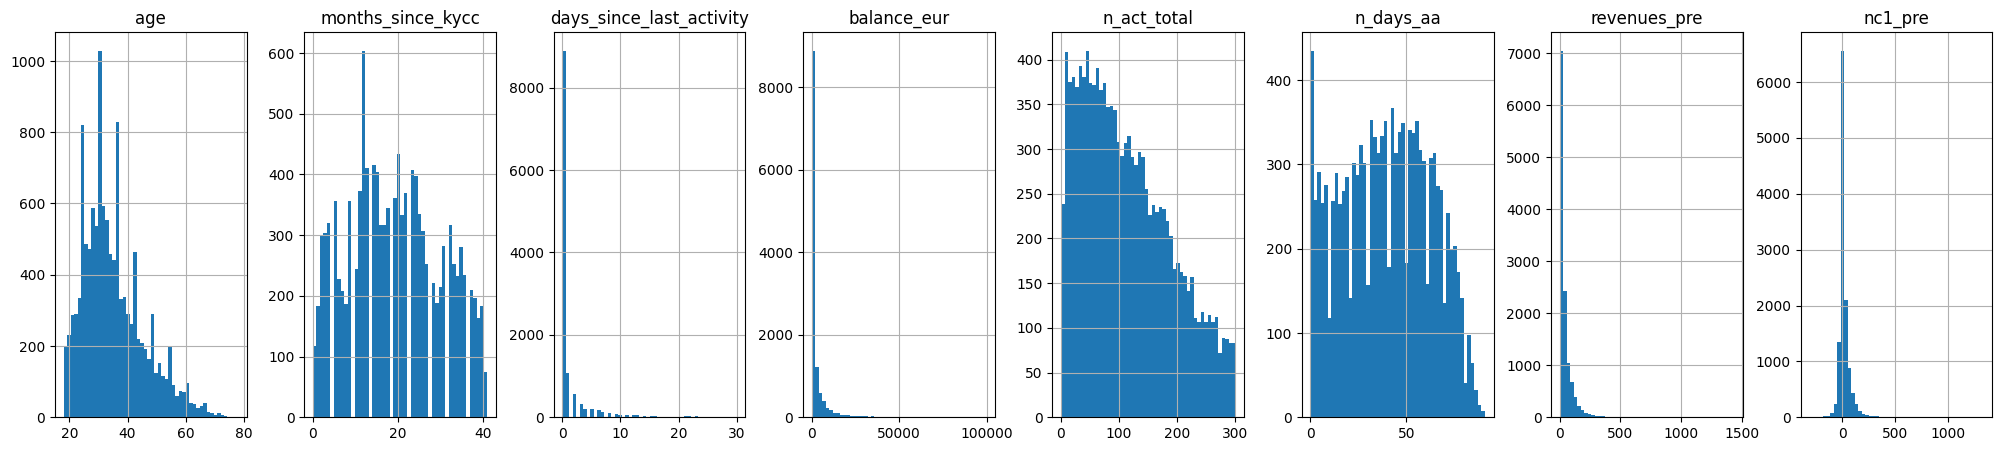

In [ ]:
cols_list = [
    "age",
    "months_since_kycc",
    "days_since_last_activity",
    "balance_eur",
    "n_act_total",
    "n_days_aa",
    "revenues_pre",
    "nc1_pre",
]
df.loc[df["bizum_user"], cols_list].hist(figsize=(25, 5), layout=(1, 8), bins=50)

array([[<AxesSubplot:title={'center':'age'}>,
        <AxesSubplot:title={'center':'months_since_kycc'}>,
        <AxesSubplot:title={'center':'days_since_last_activity'}>,
        <AxesSubplot:title={'center':'balance_eur'}>,
        <AxesSubplot:title={'center':'n_act_total'}>,
        <AxesSubplot:title={'center':'n_days_aa'}>,
        <AxesSubplot:title={'center':'revenues_pre'}>,
        <AxesSubplot:title={'center':'nc1_pre'}>]], dtype=object)

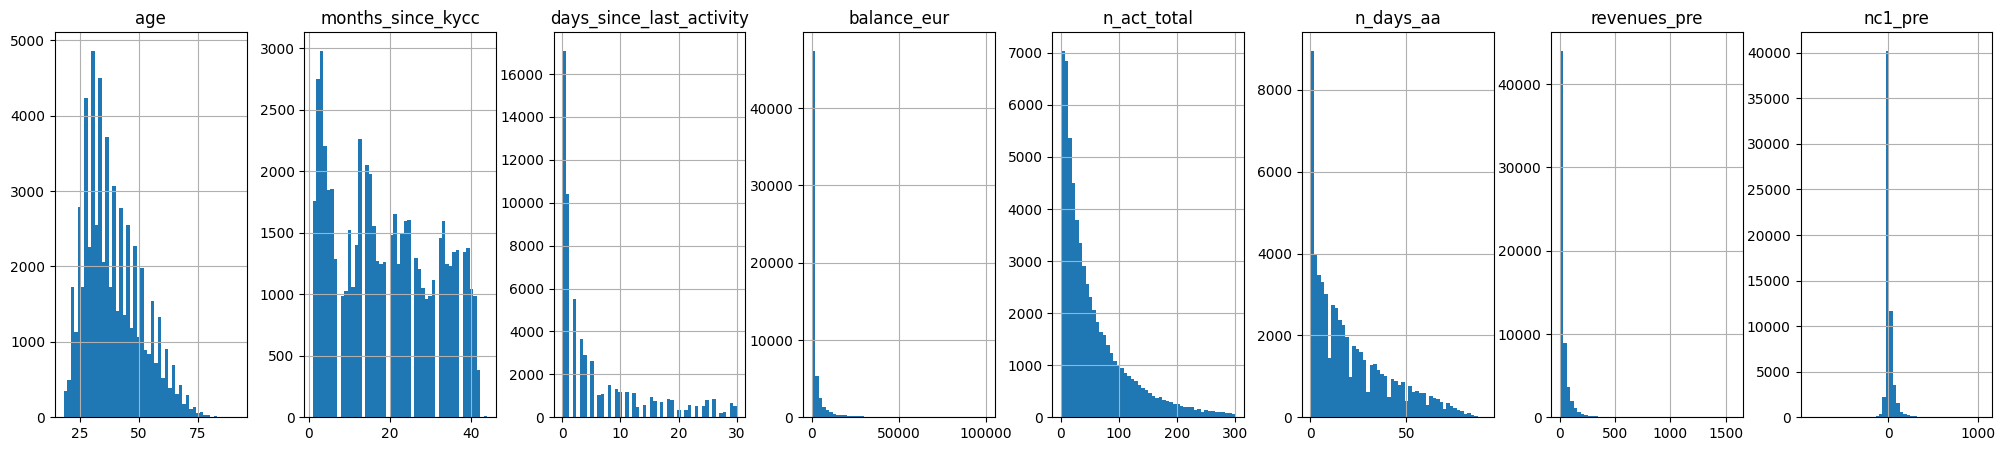

In [ ]:
df.loc[~df["bizum_user"], cols_list].hist(figsize=(25, 5), layout=(1, 8), bins=50)

In [ ]:
# changing values from 0 to 1 because the following features will be log-transformed
df.loc[df["days_since_last_activity"] == 0, "days_since_last_activity"] = 1
df.loc[df["n_days_aa"] <= 1, "n_days_aa"] = np.mean(df["n_days_aa"])

In [ ]:
df = df.loc[df["days_since_last_activity"] <= 10, :].reset_index(drop=True)

In [ ]:
df.loc[df["balance_eur"] >= 20000, "balance_eur"] = 20000
df.loc[df["n_act_total"] >= 100, "n_act_total"] = 100
# df.loc[ df['frequency_score'] <= 0.4, 'frequency_score'] = 0.4

In [ ]:
df = df[(np.abs(stats.zscore(df["nc1"])) < 3)].reset_index(drop=True)

<br>
<br>
<br>
<br>
<br>
<br>

### Naive comparison of revenue and net contribution 1 in the 6 months after launch

---

In [ ]:
df.groupby(["bizum_user"]).mean()

,is_expat,last_login_os,age,months_since_kycc,days_since_last_activity,no_physical_cards_flg,frequency_score,inactivity_length_ratio,balance_eur,n_act_total,n_days_aa,revenues_pre,nc1_pre,nc1,revenues
bizum_user,,,,,,,,,,,,,,,
False,0.384178,1.422835,38.759294,19.677524,2.557245,0.177693,0.682927,2.190493,2065.293066,51.477926,27.213850,30.388677,13.191966,17.519152,30.526700
True,0.552574,1.462186,34.763046,19.288617,1.520969,0.115916,0.801815,0.582398,2359.554897,76.801945,41.219892,38.701863,11.865139,22.007758,48.049929


In [ ]:
df.groupby(["bizum_user"])["user_created"].count()

bizum_user
False    47340
True     11517
Name: user_created, dtype: int64

In [ ]:
df.groupby(["bizum_user"])["revenues"].describe()

,count,mean,std,min,25%,50%,75%,max
bizum_user,,,,,,,,
False,47340.0,30.526700,44.071934,0.0,3.700452,12.244054,37.880867,717.966620
True,11517.0,48.049929,52.584739,0.0,11.153234,28.901362,65.263551,426.499847


In [ ]:
df.groupby(["bizum_user"])["nc1"].describe()

,count,mean,std,min,25%,50%,75%,max
bizum_user,,,,,,,,
False,47340.0,17.519152,40.050894,-176.766293,-1.201827,3.829650,25.148999,229.592122
True,11517.0,22.007758,49.587711,-178.465019,-3.659263,8.731512,39.807419,229.458824


In [ ]:
# separate control and treatment for t-test
df_control = df.loc[~df["bizum_user"]]
df_treatment = df.loc[df["bizum_user"]]

net contribution 1

In [ ]:
from scipy.stats import ttest_ind

print(df_control.nc1.mean(), df_treatment.nc1.mean())

# compare samples
_, p = ttest_ind(df_control["nc1"], df_treatment["nc1"])
print(f"p={p:.3f}")

# interpret
alpha = 0.05  # significance level

if p > alpha:
    print(
        "same distributions/same group mean (fail to reject H0 - we do not have enough evidence to reject H0)"
    )
else:
    print("different distributions/different group mean (reject H0)")

17.519151966523086 22.007757760445344
p=0.000
different distributions/different group mean (reject H0)


revenues

In [ ]:
from scipy.stats import ttest_ind

print(df_control.revenues.mean(), df_treatment.revenues.mean())

# compare samples
_, p = ttest_ind(df_control["revenues"], df_treatment["revenues"])
print(f"p={p:.3f}")

# interpret
alpha = 0.05  # significance level
if p > alpha:
    print(
        "same distributions/same group mean (fail to reject H0 - we do not have enough evidence to reject H0)"
    )
else:
    print("different distributions/different group mean (reject H0)")

30.526699810711403 48.04992856432973
p=0.000
different distributions/different group mean (reject H0)


<br>
<br>
<br>
<br>
<br>
<br>


### Feature engineering - one hot encoding of categorical variables

---
<br>
<br>



we leave out features such as use_case because they are not directly observable and could introduce bias.

In [ ]:
df.columns

Index(['user_id', 'user_created', 'kyc_first_completed', 'tier', 'is_personal',
       'is_newstandard', 'is_expat', 'gender', 'last_login_os', 'age',
       'months_since_kycc', 'days_since_last_activity', 'use_case',
       'no_physical_cards_flg', 'frequency_score', 'inactivity_length_ratio',
       'balance_eur', 'n_act_total', 'n_days_aa', 'revenues_pre', 'nc1_pre',
       'bizum_user', 'nc1', 'revenues'],
      dtype='object')

In [ ]:
user_features = [
    "user_id",
    "user_created",
    "kyc_first_completed",
]

categorical_features = [
    "tier",
    "is_personal",
    "is_newstandard",
    "is_expat",
    "gender",
    "bizum_user",
    "no_physical_cards_flg",
]

features_to_scale = [
    "last_login_os",
    "age",
    "months_since_kycc",
]

features_to_log = [
    "days_since_last_activity",
    "n_act_total",
    "n_days_aa",
    "balance_eur",
    "revenues_pre",
    "nc1_pre",
    # 'frequency_score',
]

target = [
    "nc1",
    # 'revenues'
]

# used for reordering columns
all_features = categorical_features + features_to_scale + features_to_log + target
df = df[all_features].reset_index(drop=True)

In [ ]:
# df_pre_transform = df.copy()

In [ ]:
df = pd.get_dummies(df, columns=categorical_features, drop_first=True)

print(df.shape)

(58857, 19)


In [ ]:
# onehotencoded_features
business_features = [f for f in df.columns if "is_personal" in f]
tier_features = [f for f in df.columns if "tier" in f]
is_newstandard_features = [f for f in df.columns if "is_newstandard" in f]
gender_features = [f for f in df.columns if "gender" in f]
expat_features = [f for f in df.columns if "is_expat" in f]
bizum_features = [f for f in df.columns if "bizum" in f]
card_features = [f for f in df.columns if "no_physical_cards_flg" in f]

ohe_features = (
    business_features
    + tier_features
    + is_newstandard_features
    + gender_features
    + expat_features
    + bizum_features
    + card_features
)

ohe_features

['is_personal_True',
 'tier_SMART',
 'tier_STANDARD',
 'tier_YOU',
 'is_newstandard_True',
 'gender_MALE',
 'is_expat_True',
 'bizum_user_True',
 'no_physical_cards_flg_1']

In [ ]:
all_features = ohe_features + features_to_scale + features_to_log + target
df = df[all_features]

<br>
<br>
<br>
<br>
<br>
<br>


### Feature engineering - logarithmic transformations and scaling

---
<br>
<br>


In [ ]:
# Preprocessing pipeline
from sklearn.preprocessing import (
    OneHotEncoder,
    StandardScaler,
    RobustScaler,
    PowerTransformer,
)
from sklearn.compose import make_column_transformer, ColumnTransformer
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer

In [ ]:
scale_pipeline = make_pipeline(StandardScaler())
log_pipeline = make_pipeline(
    RobustScaler(), PowerTransformer(standardize=True)
)  # https://github.com/scikit-learn/scikit-learn/issues/14959

preprocessor = ColumnTransformer(
    transformers=[
        ("scale", scale_pipeline, features_to_scale),
        ("log_transform", log_pipeline, features_to_log),
    ],
    remainder="passthrough",
)

In [ ]:
# print(features_to_scale)
# print(features_to_log)
# print(df.columns)

In [ ]:
df_fittransform = pd.DataFrame(
    preprocessor.fit_transform(df[features_to_scale + features_to_log + target]),
    columns=df[features_to_scale + features_to_log + target].columns,
)

In [ ]:
df_fittransform.head()

,last_login_os,age,months_since_kycc,days_since_last_activity,n_act_total,n_days_aa,balance_eur,revenues_pre,nc1_pre,nc1
0,-0.699224,-1.429155,1.389903,-0.754776,1.220161,1.003675,-1.154080,-0.378599,-1.167904,-2.886850
1,0.924858,1.432973,1.389903,-0.754776,1.220161,1.630806,1.097196,0.164366,-0.778156,-16.135438
2,0.924858,-0.250631,1.389903,-0.754776,0.725954,0.205129,1.028211,0.550602,-0.898752,-74.343768
3,0.924858,-1.344974,1.305145,-0.754776,1.220161,0.931240,-0.451561,-0.725532,-0.292450,-5.656432
4,0.924858,-1.429155,1.220388,-0.754776,1.220161,0.931240,-1.185461,1.096189,0.631339,17.514357


In [ ]:
cols_list

['age',
 'months_since_kycc',
 'days_since_last_activity',
 'balance_eur',
 'n_act_total',
 'n_days_aa',
 'revenues_pre',
 'nc1_pre']

array([[<AxesSubplot:title={'center':'age'}>,
        <AxesSubplot:title={'center':'months_since_kycc'}>,
        <AxesSubplot:title={'center':'days_since_last_activity'}>,
        <AxesSubplot:title={'center':'balance_eur'}>,
        <AxesSubplot:title={'center':'n_act_total'}>,
        <AxesSubplot:title={'center':'n_days_aa'}>,
        <AxesSubplot:title={'center':'revenues_pre'}>,
        <AxesSubplot:title={'center':'nc1_pre'}>]], dtype=object)

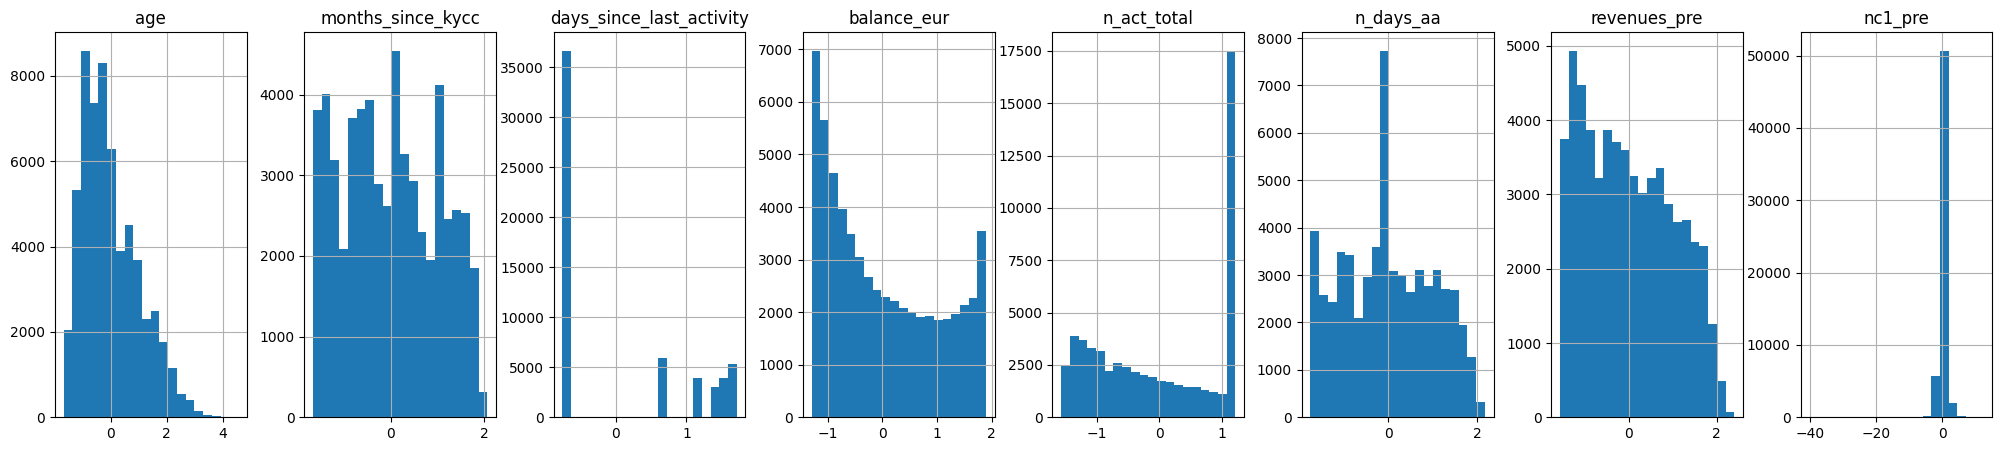

In [ ]:
df_fittransform.loc[:, cols_list].hist(figsize=(25, 5), layout=(1, 8), bins=20)

In [ ]:
# Join transformed columns on existing df, remove pre-transformation features
df = df.loc[
    :,
    ~df.columns.isin(features_to_scale + features_to_log + target),
].join(df_fittransform)

<br>
<br>
<br>
<br>
<br>
<br>

### Propensity score matching - matching users based on their likelihood to redeem the coupon

---

<br>
<br>

In [202]:
from sklearn.linear_model import LogisticRegression

In [203]:
t = "bizum_user_True"
y = "nc1"
exclude_col = "revenues"

x = [f for f in df.columns if f not in t + y + exclude_col]

In [204]:
print(df[x].columns)
print(df[[t]].columns)
print(df[[y]].columns)

Index(['is_personal_True', 'tier_SMART', 'tier_STANDARD', 'tier_YOU',
       'is_newstandard_True', 'gender_MALE', 'is_expat_True',
       'no_physical_cards_flg_1', 'last_login_os', 'age', 'months_since_kycc',
       'days_since_last_activity', 'n_act_total', 'n_days_aa', 'balance_eur'],
      dtype='object')
Index(['bizum_user_True'], dtype='object')
Index(['nc1'], dtype='object')


In [205]:
ps_scores_model = LogisticRegression().fit(df[x], df[t])

In [206]:
ps_scores = df.assign(propensity_score=ps_scores_model.predict_proba(df[x])[:, 1])
df_final = ps_scores[["propensity_score", t, y]]

In [207]:
df_final.head()

,propensity_score,bizum_user_True,nc1
0,0.493405,1,1.481138
1,0.133248,1,27.111183
2,0.237870,1,-32.888848
3,0.419790,1,34.065367
4,0.443602,1,-1.059133


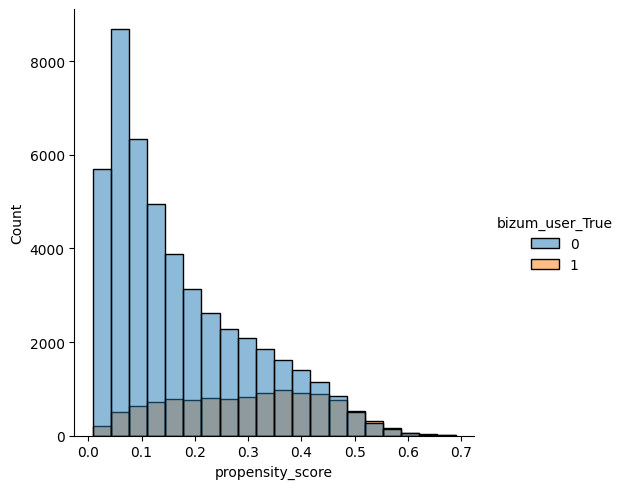

In [208]:
# Plotting the propensity score distribution to make sure there's big enough overlapped between the two groups
sns.displot(data=df_final, x=df_final["propensity_score"], hue=t, bins=20)

<br>
<br>
<br>
<br>
<br>
<br>

### Propensity score matching - compare characteristics of users that started using Bizum and those that never did

---

<br>
<br>

In [ ]:
# df_test = df_pre_transform.assign(propensity_score=ps_scores_model.predict_proba(df[x])[:, 1])

In [ ]:
# df_test['propensity_score'] = df_test['propensity_score'].round(1)

In [ ]:
# df_test.columns

In [ ]:
# df_test.loc[df_test['propensity_score']<=0.2].groupby(['bizum_user']).mean()

In [ ]:
# df_test.loc[df_test['propensity_score']<=0.2].groupby(['bizum_user'])['tier', 'is_personal', 'is_newstandard'].count()

<br>
<br>
<br>
<br>
<br>
<br>

### OLS estimation - Regressing NC1 with the propensity score and coupon boolean

---

<br>
<br>

In [ ]:
# !pip3 install statsmodels

In [209]:
# ols estimation - Regressing NC1 with the propensity score and coupon boolean, focusing on the coefficient of redeemed_coupon_True
import statsmodels.formula.api as smf

In [210]:
smf.ols(f"{y} ~ {t} + propensity_score", data=df_final).fit().summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,10.7588,0.294,36.577,0.000,10.182,11.335
bizum_user_True,-0.7470,0.464,-1.609,0.108,-1.657,0.163
propensity_score,40.2049,1.305,30.816,0.000,37.648,42.762


<br>
<br>
<br>
<br>
<br>
<br>

### causal inference

---

<br>
<br>

In [ ]:
# !pip3 install causalinference

In [ ]:
# # Using the Python package based on the propensity score method to directly get the ATE

# from causalinference import CausalModel

# cm = CausalModel(
#     Y=df_final[y].values,
#     D=df_final[t].values,
#     X=df_final[["propensity_score"]].values,
# )

# cm.est_via_matching(matches=1, bias_adj=True)

# print(cm.estimates)

<br>
<br>
<br>
<br>
<br>
<br>

# Difference in differences

---

<br>
<br>

In [ ]:
bizum_did = """
-- bizum_DIDs
with bizum_status as (
    select
        u.user_created,
        min(created) as bizum_start_ts
    from
        dbt.zrh_users u
    inner join
        beryl_user b on b.id = u.user_id
            and status = 'SIGNED_UP'
    where
        1=1
    group by 1

), net_contribution as (
    select
        u.user_created,
        sum(case when to_date(p.month, 'YYYY-MM') <= '2022-09-01' and type = 'Revenue' then value end)::float / 100 as revenues_pre,
        sum(case when to_date(p.month, 'YYYY-MM') >= '2022-10-01' and type = 'Revenue' then value end)::float / 100 as revenues_post,
        sum(case when to_date(p.month, 'YYYY-MM') <= '2022-09-01' then value end)::float / 100 as nc1_pre,
        sum(case when to_date(p.month, 'YYYY-MM') >= '2022-10-01' then value end)::float / 100 as nc1_post
    from
        dbt.stg_users u
    inner join
        dbt.ucm_pnl p using (user_created)
    inner join
        (select * from dbt.ucm_mapping where 1=1 and type in ('Revenue', 'Direct', 'Variable')) l using (label)
    where
        1=1
        and to_date(p.month, 'YYYY-MM') >= '2022-04-01'
        and to_date(p.month, 'YYYY-MM') <= '2023-03-01'
    group by 1

), final as (
    select
        u.user_id,
        bs.user_created is not null as bizum_user,
        revenues_pre,
        revenues_post,
        nc1_pre,
        nc1_post
    from
        dbt.zrh_users u
    inner join
        net_contribution nc using (user_created)
    left join
        bizum_status bs using (user_created)
    where
        1=1
        and tnc_country_group = 'ESP'
        and kyc_first_completed <= '2022-03-01'
        and (bizum_start_ts < '2022-10-01' or bs.user_created is null)
        and legal_entity = 'ES' -- all bizum users are ES
        and is_fraudster is false

)

(select * from final where bizum_user is true)
UNION ALL
(select * from final where bizum_user is false order by random() limit 100000);
"""

In [258]:
df = pd.read_csv("bizum_DIDs.csv")

In [259]:
df.head()

,user_id,bizum_user,revenues_pre,revenues_post,nc1_pre,nc1_post
0,6216d61f-5ad5-42af-b201-efdfd3161d37,True,5.888917,13.652315,2.659193,7.546169
1,bd3c5367-f872-4b30-bbf9-4bcc54f27460,True,1.536885,3.251113,-1.419065,-0.204653
2,967b655c-d358-4661-90e8-173f007707d3,True,16.741253,15.129977,-13.823550,-3.991110
3,8bdd1c54-55b8-4f26-92ca-020702757d5e,True,20.104985,18.276456,-13.362111,16.434007
4,38e04cfa-c906-4430-9c46-f0b9ebb4a8d4,True,14.801884,21.672511,-28.926932,5.151790


In [260]:
df = df.fillna(0)

<AxesSubplot:xlabel='nc1_pre', ylabel='nc1_post'>

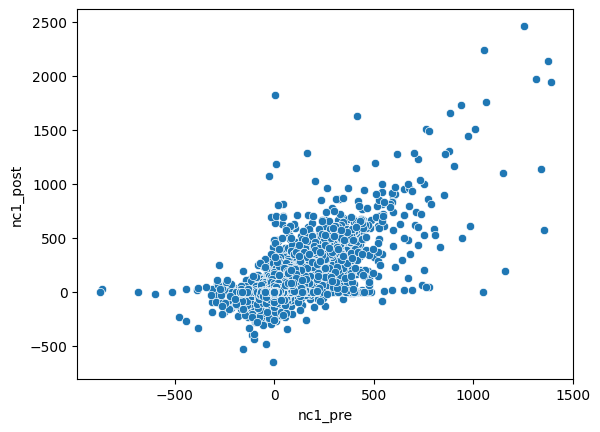

In [271]:
sns.scatterplot(data=df, x="nc1_pre", y="nc1_post")

In [261]:
df.groupby("bizum_user").mean()

,revenues_pre,revenues_post,nc1_pre,nc1_post
bizum_user,,,,
False,15.349955,15.440649,8.008145,9.659610
True,45.200687,55.871806,17.809455,27.202497


In [262]:
# separate control and treatment for t-test
df_control = df.loc[~df["bizum_user"]]
df_treatment = df.loc[df["bizum_user"]]

In [ ]:
df_control_pre_mean = df_control.revenues_pre.mean()
df_control_post_mean = df_control.revenues_post.mean()
df_treatment_pre_mean = df_treatment.revenues_pre.mean()
df_treatment_post_mean = df_treatment.re_post.mean()

print(
    f"the DIDs in revenues in the 6 months after launch is {((df_treatment_post_mean - df_treatment_pre_mean) - (df_control_post_mean - df_control_pre_mean)):.3f} Euros"
)

the DIDs in revenues in the 6 months after launch is 10.580 Euros


In [263]:
df_control_pre_mean = df_control.nc1_pre.mean()
df_control_post_mean = df_control.nc1_post.mean()
df_treatment_pre_mean = df_treatment.nc1_pre.mean()
df_treatment_post_mean = df_treatment.nc1_post.mean()

print(
    f"the DIDs in NC 1 in the 6 months after launch is {((df_treatment_post_mean - df_treatment_pre_mean) - (df_control_post_mean - df_control_pre_mean)):.3f} Euros"
)

the DIDs in NC 1 in the 6 months after launch is 7.742 Euros


In [264]:
df["bizum_user"] = df["bizum_user"].astype(int)

In [265]:
# group g: 0 control group (PA), 1 treatment group (NJ)
# t: 0 before treatment (min wage raise), 1 after treatment
# gt: interaction of g * t

# data before the treatment
df_before = df[["nc1_pre", "bizum_user"]].copy()
df_before["t"] = 0
df_before.columns = ["nc1", "g", "t"]

# data after the treatment
df_after = df[["nc1_post", "bizum_user"]].copy()
df_after["t"] = 1
df_after.columns = ["nc1", "g", "t"]

In [266]:
# data for regression
df_reg = pd.concat([df_before, df_after])

# create the interaction
df_reg["gt"] = df_reg["g"] * df_reg["t"]

df_reg.head()

,nc1,g,t,gt
0,2.659193,1,0,0
1,-1.419065,1,0,0
2,-13.823550,1,0,0
3,-13.362111,1,0,0
4,-28.926932,1,0,0


In [277]:
# sns.displot(data=df_reg, x='nc1', hue='g', kind='hist')

<AxesSubplot:xlabel='t', ylabel='nc1'>

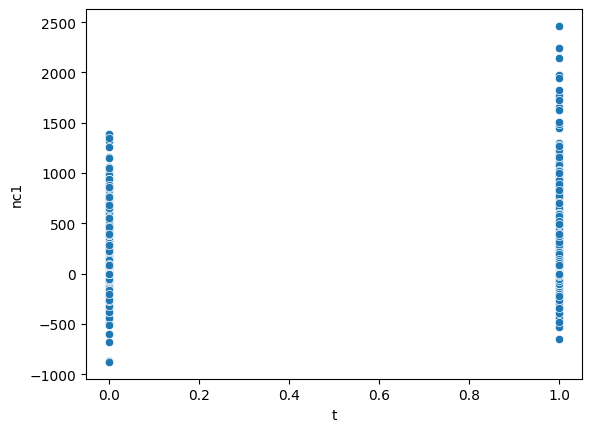

In [279]:
sns.scatterplot(data=df_reg, x="t", y="nc1")

In [267]:
from sklearn.linear_model import LinearRegression

L = LinearRegression()

X = df_reg[["g", "t", "gt"]]
y = df_reg.nc1

L.fit(X, y)
L.coef_  # the coefficient for gt is the DID, which is 2.75

array([17.69492156])

In [268]:
# regression via statsmodels
# result is not significant

from statsmodels.formula.api import ols

ols = ols("nc1 ~ g + t + gt", data=df_reg).fit()
print(ols.summary())

                            OLS Regression Results                            
Dep. Variable:                    nc1   R-squared:                       0.008
Model:                            OLS   Adj. R-squared:                  0.008
Method:                 Least Squares   F-statistic:                     1807.
Date:                Mon, 24 Apr 2023   Prob (F-statistic):               0.00
Time:                        13:04:52   Log-Likelihood:            -1.2445e+06
No. Observations:              232460   AIC:                         2.489e+06
Df Residuals:                  232458   BIC:                         2.489e+06
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      9.5076      0.110     86.438      0.0

<br>
<br>
<br>
<br>
<br>
<br>

# Manually matching users from the two groups using K-Nearest Neighbors

---

<br>
<br>

In [45]:
from sklearn.neighbors import KNeighborsRegressor

In [46]:
df.head()

,is_personal_True,tier_SMART,tier_STANDARD,tier_YOU,is_newstandard_True,gender_MALE,is_expat_True,bizum_user_True,no_physical_cards_flg_1,last_login_os,age,months_since_kycc,days_since_last_activity,n_act_total,n_days_aa,balance_eur,revenues_pre,nc1_pre,nc1
0,1,0,1,0,0,1,0,1,0,-0.699224,-1.429155,1.389903,-0.754776,1.220161,1.003675,-1.154080,-0.378599,-1.167904,-2.886850
1,1,0,1,0,0,1,0,1,0,0.924858,1.432973,1.389903,-0.754776,1.220161,1.630806,1.097196,0.164366,-0.778156,-16.135438
2,1,0,1,0,0,1,1,1,0,0.924858,-0.250631,1.389903,-0.754776,0.725954,0.205129,1.028211,0.550602,-0.898752,-74.343768
3,1,0,1,0,0,0,1,1,0,0.924858,-1.344974,1.305145,-0.754776,1.220161,0.931240,-0.451561,-0.725532,-0.292450,-5.656432
4,0,0,1,0,0,1,0,1,0,0.924858,-1.429155,1.220388,-0.754776,1.220161,0.931240,-1.185461,1.096189,0.631339,17.514357


In [47]:
bizum = df.loc[df["bizum_user_True"] == 1]
non_bizum = df.loc[df["bizum_user_True"] == 0]

In [48]:
t = "bizum_user_True"
y = "nc1"
exclude_col = "revenues"

columns = [f for f in df.columns if f not in t + y + exclude_col]

In [49]:
columns

['is_personal_True',
 'tier_SMART',
 'tier_STANDARD',
 'tier_YOU',
 'is_newstandard_True',
 'gender_MALE',
 'is_expat_True',
 'no_physical_cards_flg_1',
 'last_login_os',
 'age',
 'months_since_kycc',
 'days_since_last_activity',
 'n_act_total',
 'n_days_aa',
 'balance_eur',
 'revenues_pre',
 'nc1_pre']

In [50]:
mt0 = KNeighborsRegressor(n_neighbors=1).fit(non_bizum[columns], non_bizum["nc1"])
mt1 = KNeighborsRegressor(n_neighbors=1).fit(bizum[columns], bizum["nc1"])

In [51]:
# match is the euro value
# for a bizum user, give me the predicted NC1 baed on their closest match.


predicted1 = pd.concat(
    [
        bizum.assign(
            match=mt0.predict(bizum[columns])
        ),  # find matches for the treated looking at the untreated knn model
        non_bizum.assign(
            match=mt1.predict(non_bizum[columns])
        ),  # find matches for the untreated looking at the treated knn model
    ]
)

In [52]:
predicted1.head()

,is_personal_True,tier_SMART,tier_STANDARD,tier_YOU,is_newstandard_True,gender_MALE,is_expat_True,bizum_user_True,no_physical_cards_flg_1,last_login_os,age,months_since_kycc,days_since_last_activity,n_act_total,n_days_aa,balance_eur,revenues_pre,nc1_pre,nc1,match
0,1,0,1,0,0,1,0,1,0,-0.699224,-1.429155,1.389903,-0.754776,1.220161,1.003675,-1.154080,-0.378599,-1.167904,-2.886850,-18.192812
1,1,0,1,0,0,1,0,1,0,0.924858,1.432973,1.389903,-0.754776,1.220161,1.630806,1.097196,0.164366,-0.778156,-16.135438,8.714827
2,1,0,1,0,0,1,1,1,0,0.924858,-0.250631,1.389903,-0.754776,0.725954,0.205129,1.028211,0.550602,-0.898752,-74.343768,-12.835547
3,1,0,1,0,0,0,1,1,0,0.924858,-1.344974,1.305145,-0.754776,1.220161,0.931240,-0.451561,-0.725532,-0.292450,-5.656432,18.522567
4,0,0,1,0,0,1,0,1,0,0.924858,-1.429155,1.220388,-0.754776,1.220161,0.931240,-1.185461,1.096189,0.631339,17.514357,57.614752


In [53]:
# nc1 vs. match is biased, not adjusted
# ATE (average treatment effect)

In [54]:
# two dimensional array
# distance is the distance between points
distances, indices = mt0.kneighbors(bizum[columns])

In [55]:
matched = []
pairs = []

In [56]:
for indexA, candidatesB in enumerate(indices):
    personA = bizum[columns].index[indexA]

    for indexB in candidatesB:
        if indexB not in matched:
            matched.append(indexB)
            personB = non_bizum[columns].index[indexB]
            pairs.append([personA, personB])
            break

matches = pd.DataFrame(pairs, columns=["SetA", "SetB"])

In [57]:
df.head()

,is_personal_True,tier_SMART,tier_STANDARD,tier_YOU,is_newstandard_True,gender_MALE,is_expat_True,bizum_user_True,no_physical_cards_flg_1,last_login_os,age,months_since_kycc,days_since_last_activity,n_act_total,n_days_aa,balance_eur,revenues_pre,nc1_pre,nc1
0,1,0,1,0,0,1,0,1,0,-0.699224,-1.429155,1.389903,-0.754776,1.220161,1.003675,-1.154080,-0.378599,-1.167904,-2.886850
1,1,0,1,0,0,1,0,1,0,0.924858,1.432973,1.389903,-0.754776,1.220161,1.630806,1.097196,0.164366,-0.778156,-16.135438
2,1,0,1,0,0,1,1,1,0,0.924858,-0.250631,1.389903,-0.754776,0.725954,0.205129,1.028211,0.550602,-0.898752,-74.343768
3,1,0,1,0,0,0,1,1,0,0.924858,-1.344974,1.305145,-0.754776,1.220161,0.931240,-0.451561,-0.725532,-0.292450,-5.656432
4,0,0,1,0,0,1,0,1,0,0.924858,-1.429155,1.220388,-0.754776,1.220161,0.931240,-1.185461,1.096189,0.631339,17.514357


In [58]:
matches.shape

(8681, 2)

In [59]:
matches.head()

,SetA,SetB
0,0,30846
1,1,26775
2,2,44626
3,3,19873
4,4,57649


In [60]:
matches = pd.merge(matches, df["nc1"], how="left", left_on="SetA", right_index=True)
matches = pd.merge(matches, df["nc1"], how="left", left_on="SetB", right_index=True)

In [63]:
matches = matches.rename(
    {
        "SetA": "bizum_user",
        "SetB": "nonbizum_user",
        "nc1_x": "nc1_bizum",
        "nc1_y": "nc1_nonbizum",
    },
    axis=1,
)

matches.head()

,bizum_user,nonbizum_user,nc1_bizum,nc1_nonbizum
0,0,30846,-2.886850,-18.192812
1,1,26775,-16.135438,8.714827
2,2,44626,-74.343768,-12.835547
3,3,19873,-5.656432,18.522567
4,4,57649,17.514357,57.614752


In [64]:
matches["diff"] = matches["nc1_bizum"] - matches["nc1_nonbizum"]
matches["diff"].mean()

1.841953118758668